In [7]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
%matplotlib inline
import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import fiona as fn
import re
import requests
from IPython.display import Image

In [8]:
# configure the inline image display
img_folder = 'images'
extension = 'png'
size = 240
dpi = 240

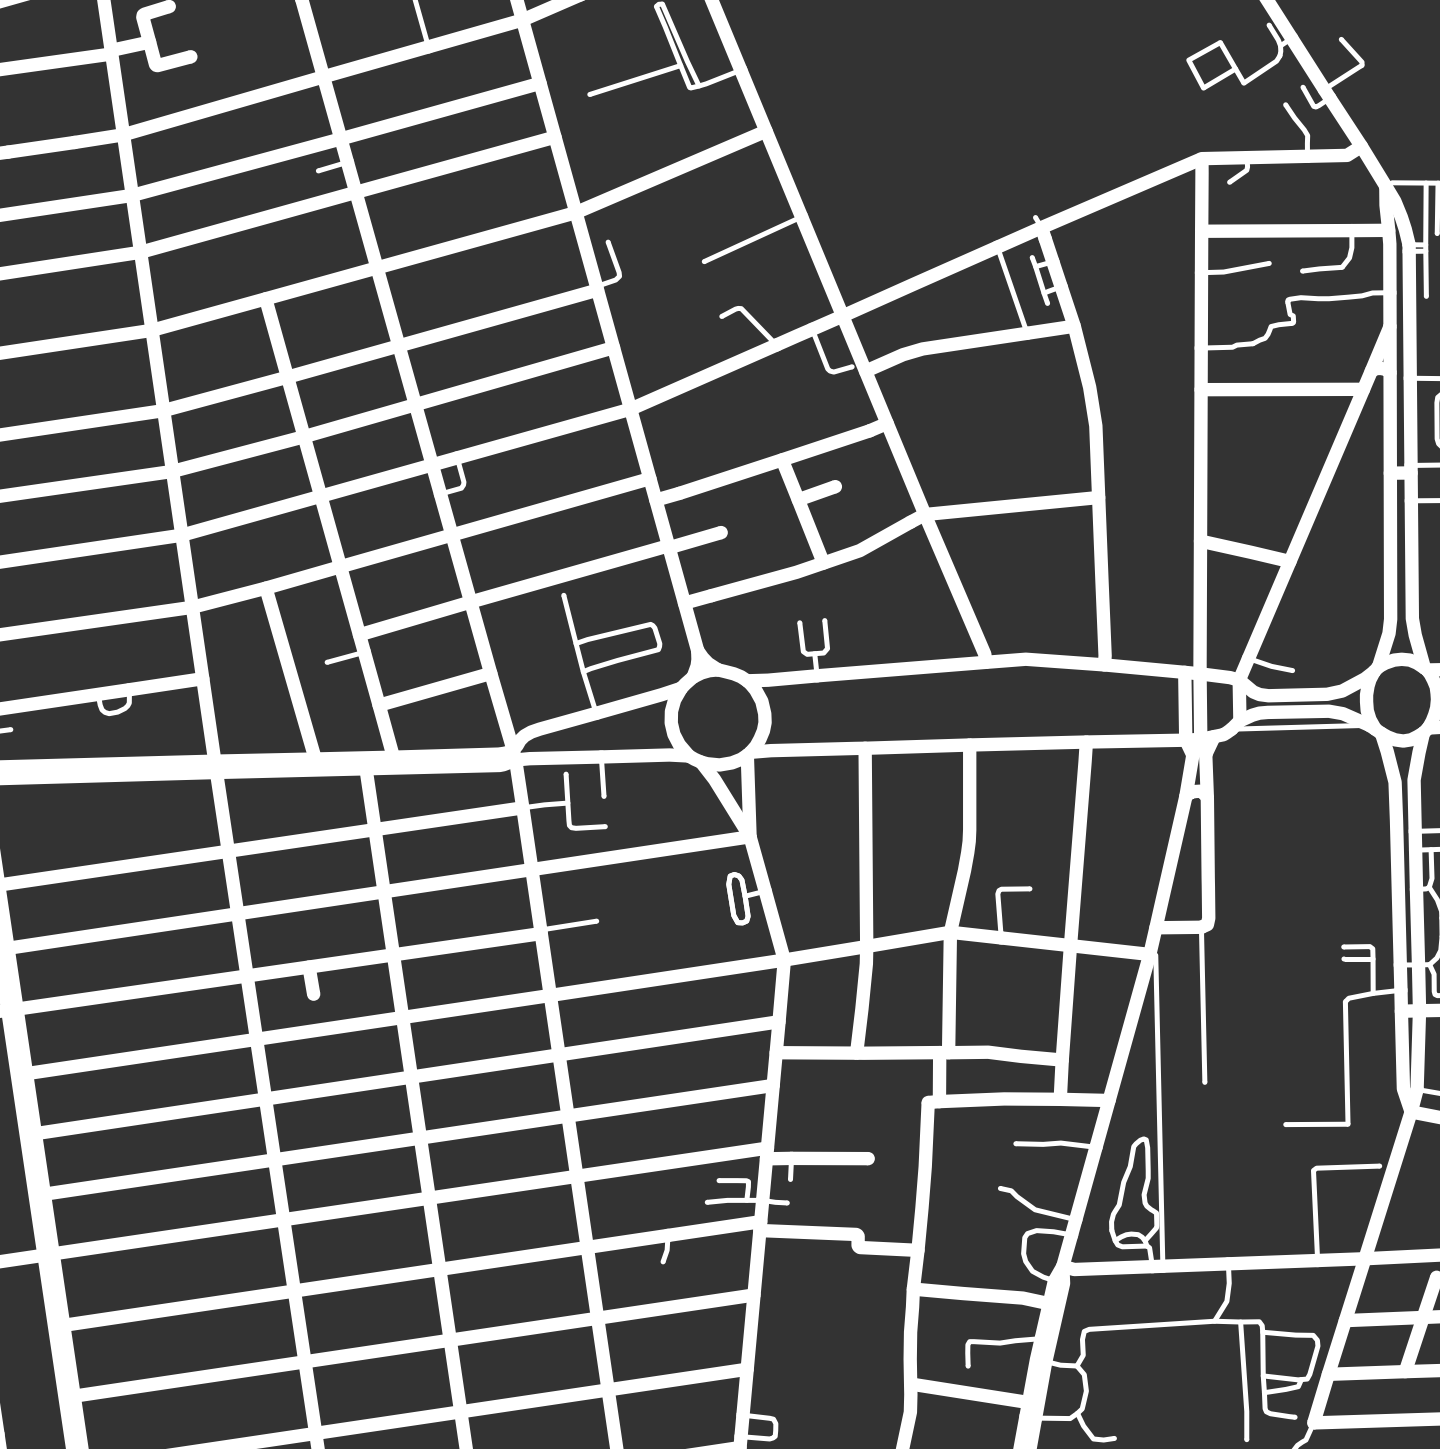

In [9]:
place = 'Phnom Penh'
point = (11.5563738, 104.92820989999996)
fig, ax = ox.plot_figure_ground(point=point, filename=place, dpi=dpi)
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)

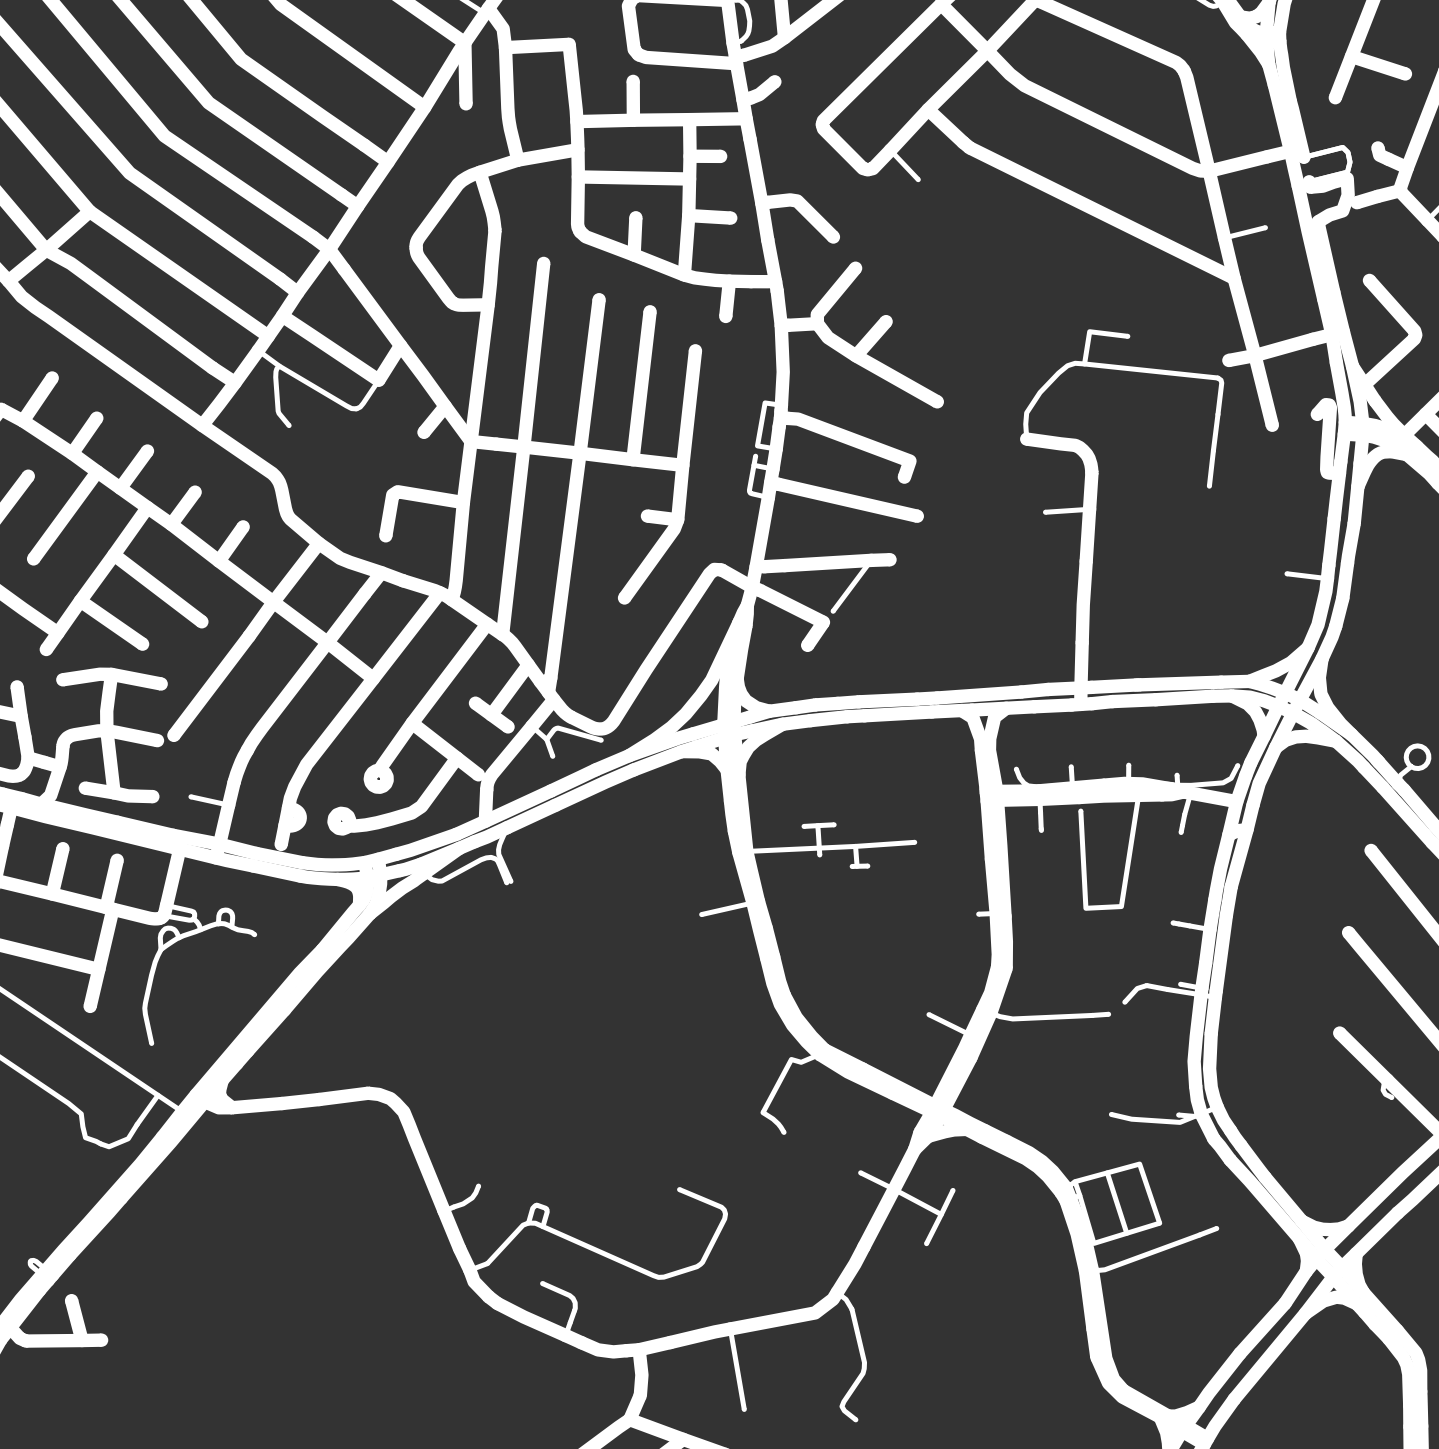

In [10]:
place = 'singapore'
point = (1.3553794,103.86774439999999)
fig, ax = ox.plot_figure_ground(point=point, filename=place, dpi=dpi)
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)

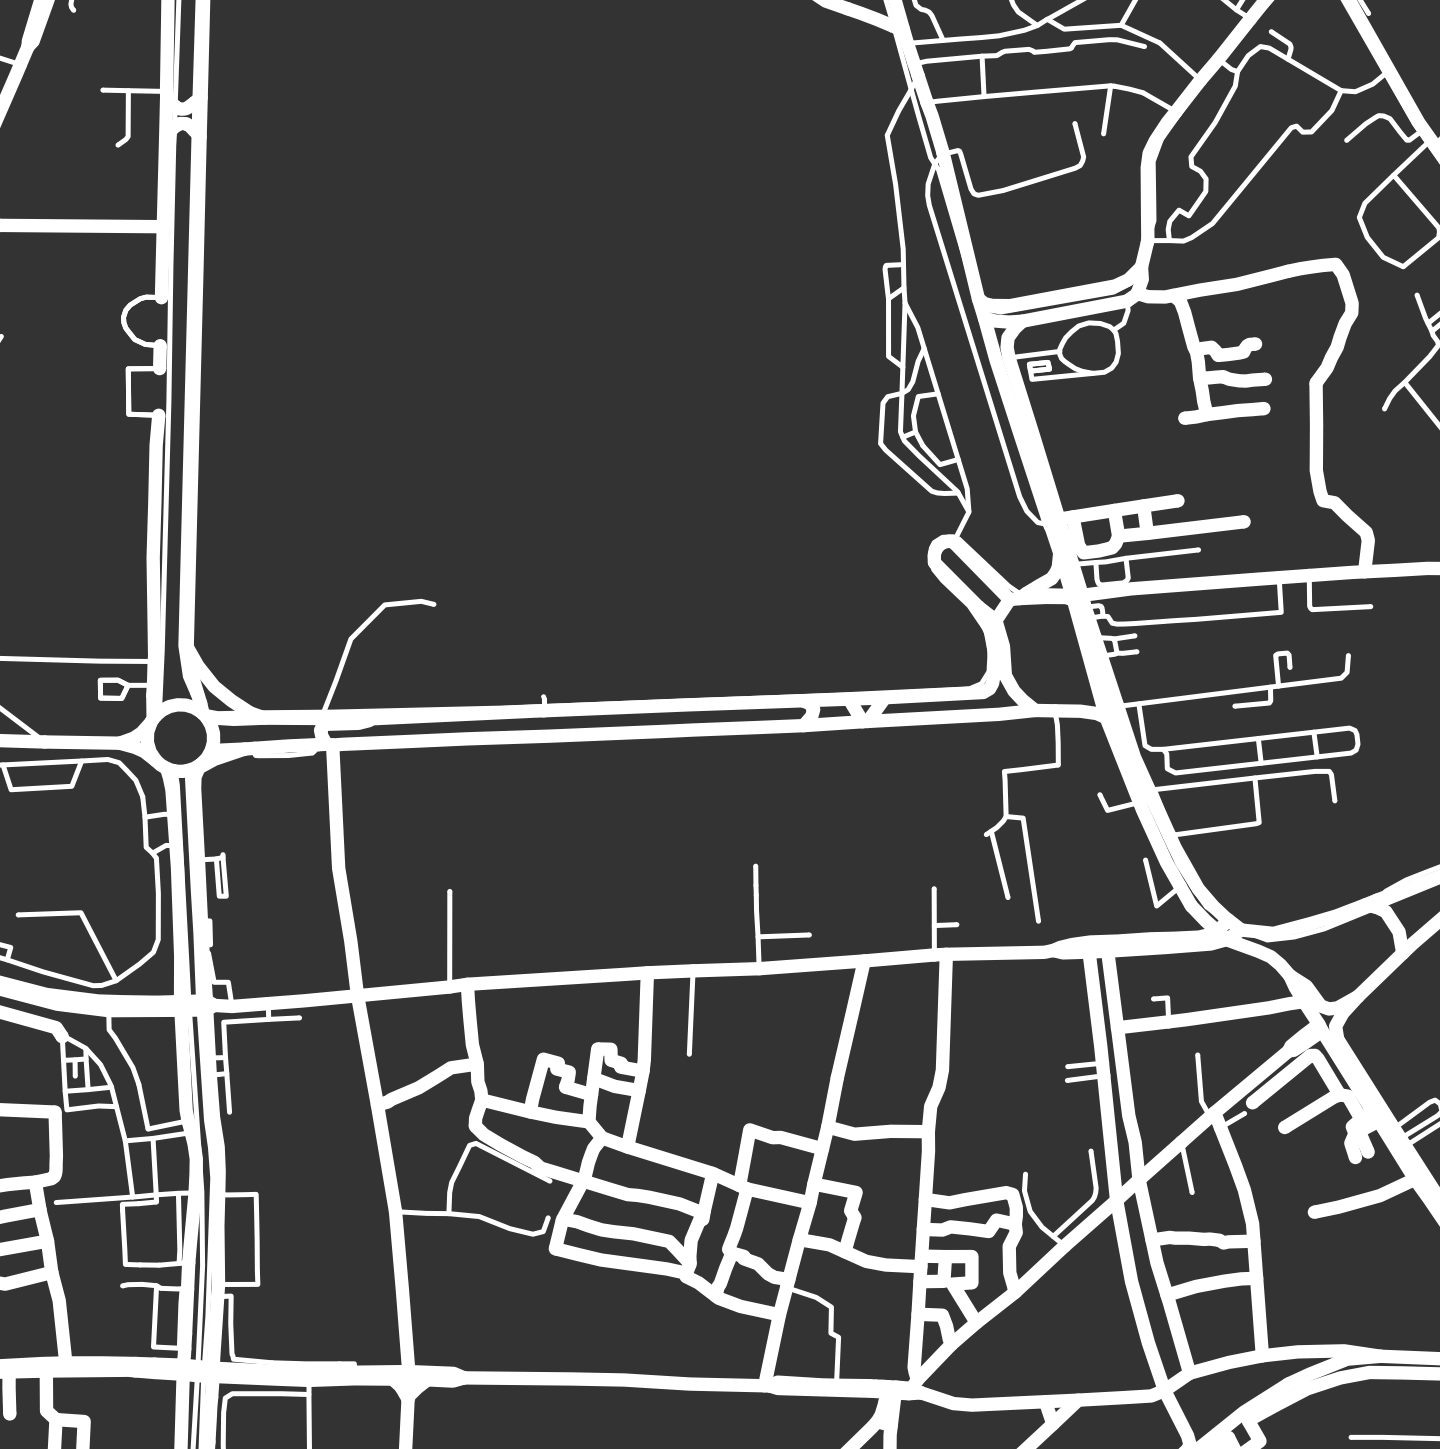

In [11]:
 place = 'Jakarta'
point = (-6.180495,106.82834149999996)
fig, ax = ox.plot_figure_ground(point=point, filename=place, dpi=dpi)
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)

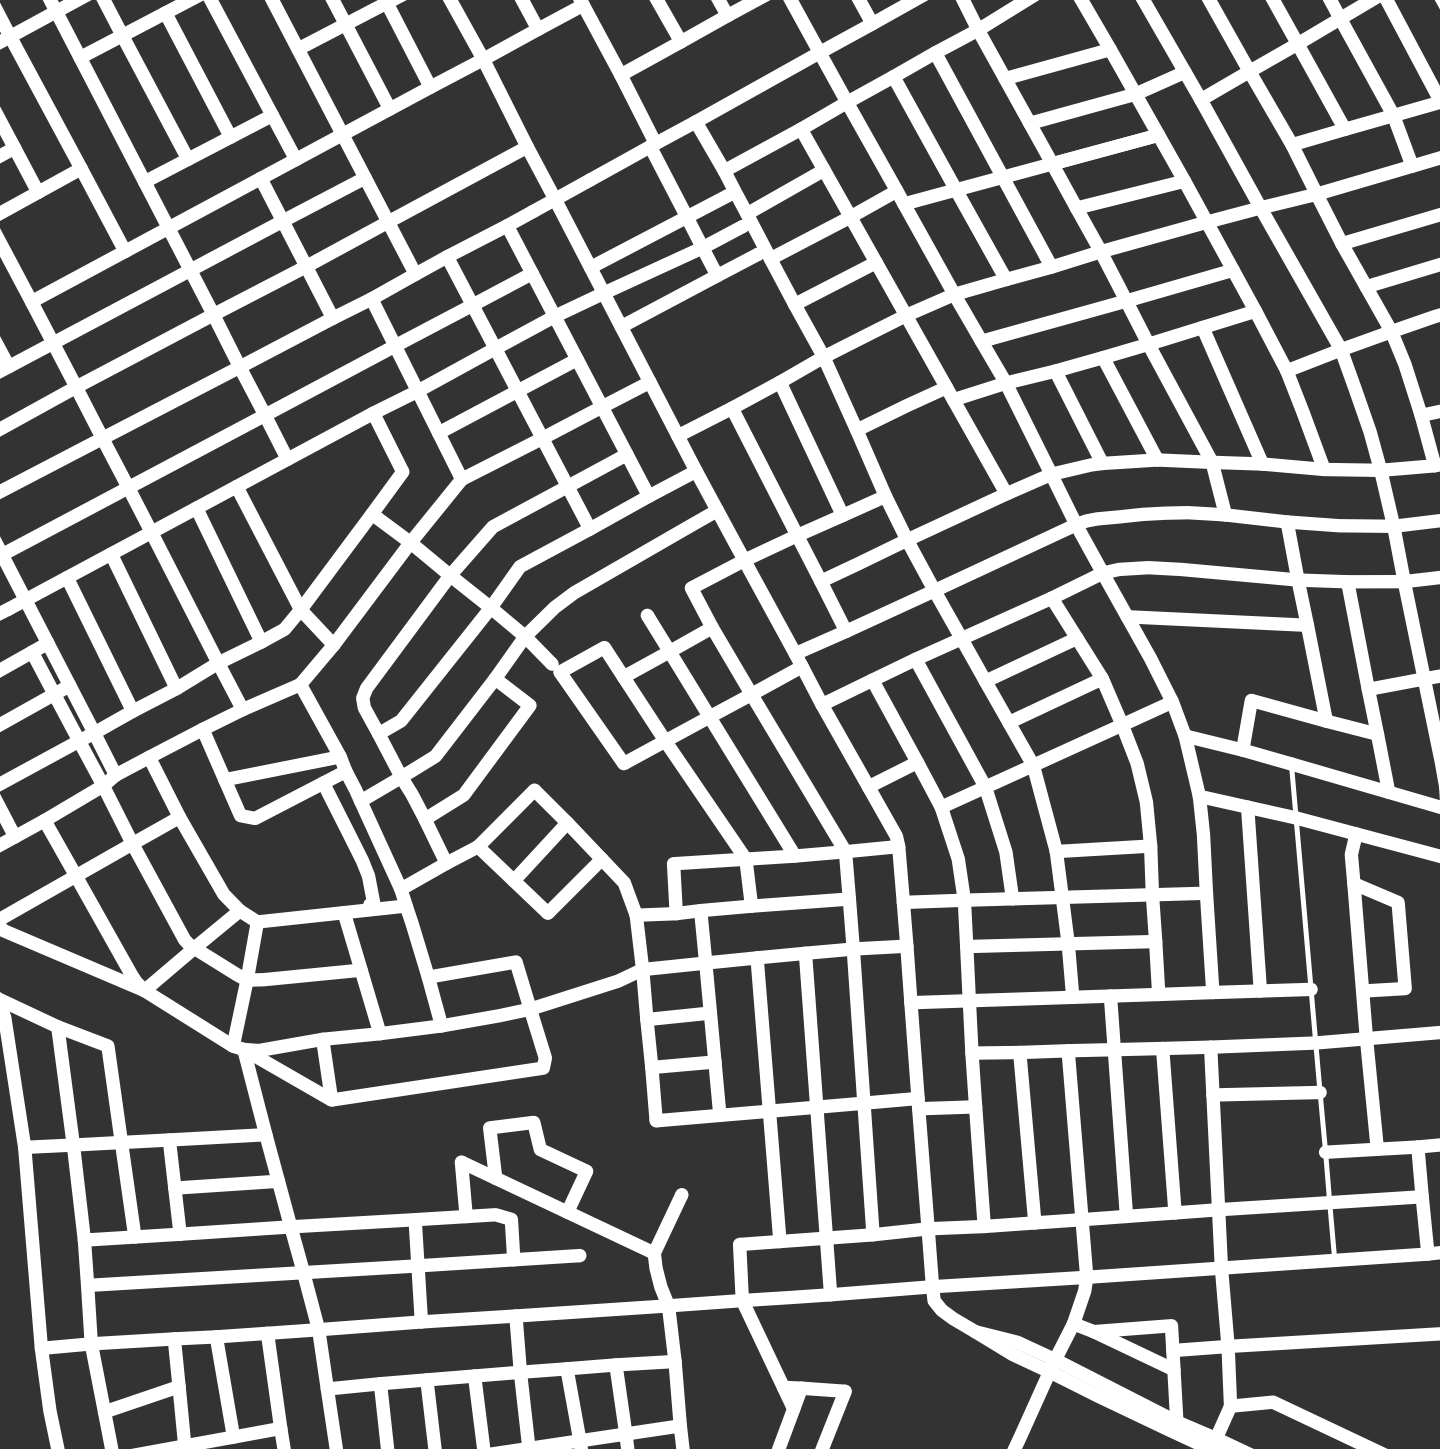

In [12]:
place = 'Yongon'
point = (16.8661, 96.1951)
fig, ax = ox.plot_figure_ground(point=point, filename=place, dpi=dpi)
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)

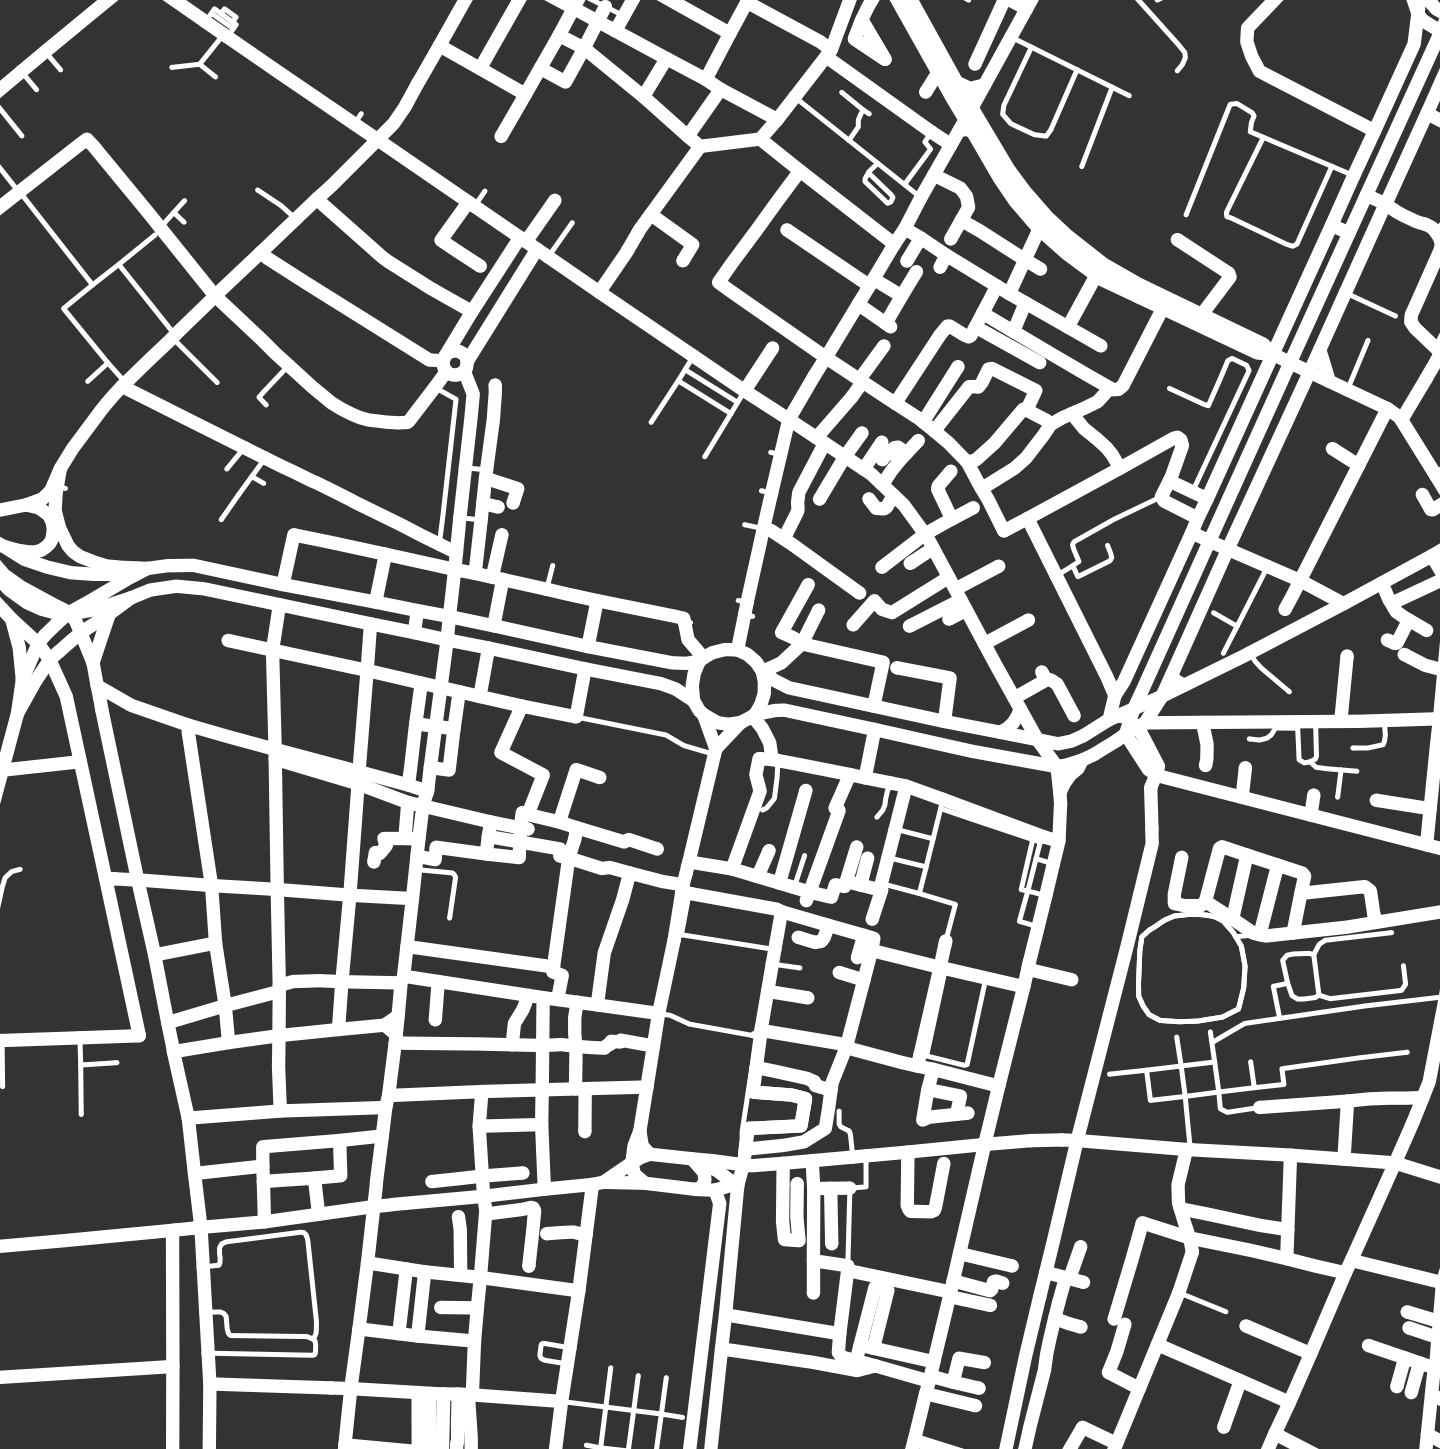

In [13]:
place = 'Bangkok'
point = (13.7563309, 100.50176510000006)
fig, ax = ox.plot_figure_ground(point=point, filename=place, dpi=dpi)
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)

In [15]:
# #Download drivable street network for "Bangkok, Thailand"
address = '13.7563309, 100.50176510000006, Thailand'
gdf = ox.gdf_from_place(address)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_address(address,distance=2500, network_type='drive')
#save graph to disk as shapefile
ox.save_graph_shapefile(G, filename='Bangkok_drivable routes')

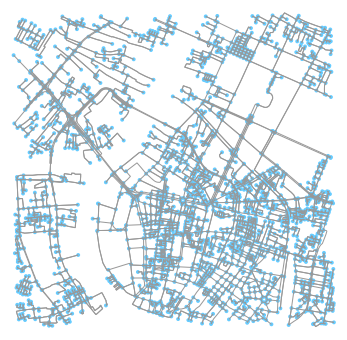

In [16]:
# Get Edges and Nodes
graph_proj = ox.project_graph(G)
fig, ax = ox.plot_graph(graph_proj)
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

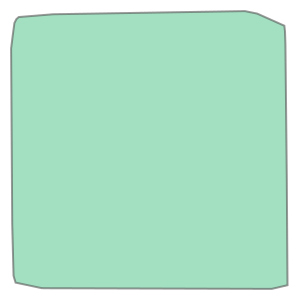

In [17]:
# Get the Convex Hull of the network
convex_hull = edges_proj.unary_union.convex_hull
# Show output
convex_hull

In [18]:
# Calculate the area
area = convex_hull.area

# Calculate statistics with density information
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

n                                                                                   2897
m                                                                                   6379
k_avg                                                                            4.40387
intersection_count                                                                  2199
streets_per_node_avg                                                             2.65274
streets_per_node_counts                {0: 0, 1: 698, 2: 19, 3: 1792, 4: 371, 5: 13, ...
streets_per_node_proportion            {0: 0.0, 1: 0.24093890231273732, 2: 0.00655850...
edge_length_total                                                                 527084
edge_length_avg                                                                  82.6281
street_length_total                                                               320917
street_length_avg                                                                84.9662
street_segments_count

In [19]:
#betweenness centrality
G_projected = ox.project_graph(G)
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(312063273, 0.26372551456475385)

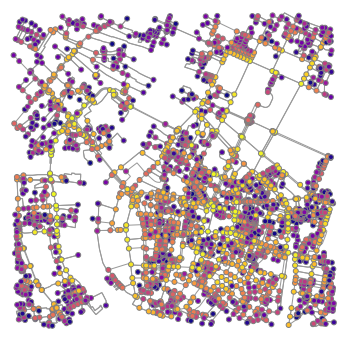

In [20]:
# get a color for each node
def get_color_list(n, color_map='plasma', start=0, end=1):
    return [cm.get_cmap(color_map)(x) for x in np.linspace(start, end, n)]

def get_node_colors_by_stat(G, data, start=0, end=1):
    df = pd.DataFrame(data=pd.Series(data).sort_values(), columns=['value'])
    df['colors'] = get_color_list(len(df), start=start, end=end)
    df = df.reindex(G.nodes())
    return df['colors'].tolist()

nc = get_node_colors_by_stat(G_projected, data=extended_stats['betweenness_centrality'])
fig, ax = ox.plot_graph(G_projected, node_color=nc, node_edgecolor='gray', node_size=25, node_zorder=2)

In [21]:
# node closeness centrality
node_centrality = nx.closeness_centrality(G)

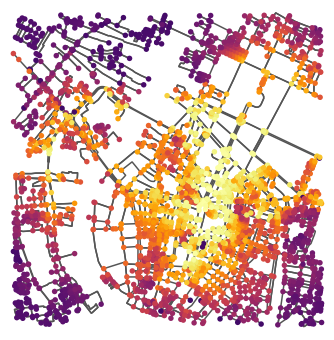

In [22]:
# plot it
df = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(G.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(G, bgcolor='w', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

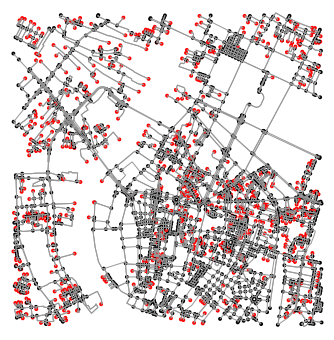

(<Figure size 437.129x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x16ad107f320>)

In [24]:
#visualize all the cul-de-sacs (or intersections of any other type) in a city to get a sense of these points of low network connectivity
# We can visualize all the cul-de-sacs for all networks
G = ox.graph_from_address(address,distance=2500, network_type='drive')
culdesacs = [key for key, value in G.graph['streets_per_node'].items() if value==1]
nc = ['r' if node in culdesacs else 'none' for node in G.nodes()]
ox.plot_graph(G, node_color=nc)

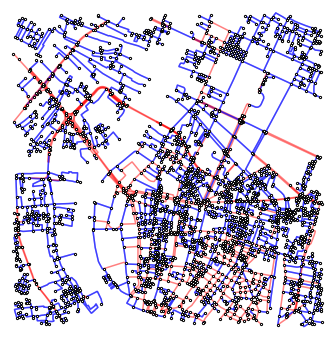

In [25]:
# highlight one-way streets
ec = ['r' if data['oneway'] else 'blue' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=5, node_zorder=3, 
                           edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

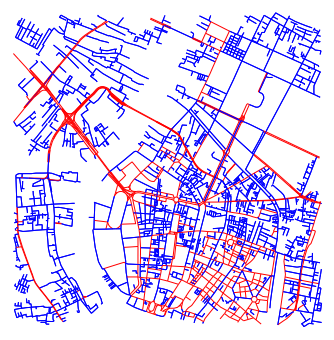

(<Figure size 437.129x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x16ac1649940>)

In [27]:
#visualize one-way vs two-way edges to provide a sense of where a city’s one-way streets and divided roads are distributed
G = ox.graph_from_address(address,distance=2500, network_type='drive')
ec = ['r' if data['oneway'] else 'blue' for u, v, key, data in G.edges(keys=True, data=True)]
ox.plot_graph(G, node_size=0, edge_color=ec)